# Transpiler support for compiling to device native 2q interactions

- Adds `TwoQToNativeEntangler` pass to replace 2Q gates with native entangling gates (plus single qubit rotations)
- Updates `ConsolidateBlocks` / `UnitarySynthesis` passes to synthesize to native entangler
- Adds `TwoQToNativeEntangler` to preset pass managers (after  embedding stage)

For testing, added `FakeNative2qMontreal` backend
- Adds 'n2q' to `configuration().basis_gates`
- Adds an 'n2q' gate to `configuration().gates` for each 2Q gate reported in the coupling_map
  - Set `qasm_def` to be a CX (matching coupling_map direction) and four random SU2's

Branch: https://github.com/kdk/qiskit-terra/tree/compile-to-native-entangling-gate

In [5]:
import qiskit as qk
from qiskit.test.mock import FakeProvider

In [6]:
provider = FakeProvider()
montreal = provider.get_backend('fake_montreal')
n2q_montreal = provider.get_backend('fake_native_2q_montreal')

In [7]:
n2q_montreal.configuration().basis_gates

['id', 'u1', 'u2', 'u3', 'cx', 'n2q']

In [8]:
from pprint import pprint 
for gate in n2q_montreal.configuration().gates:
    pprint(gate.to_dict())

{'coupling_map': [[0],
                  [1],
                  [2],
                  [3],
                  [4],
                  [5],
                  [6],
                  [7],
                  [8],
                  [9],
                  [10],
                  [11],
                  [12],
                  [13],
                  [14],
                  [15],
                  [16],
                  [17],
                  [18],
                  [19],
                  [20],
                  [21],
                  [22],
                  [23],
                  [24],
                  [25],
                  [26]],
 'name': 'id',
 'parameters': [],
 'qasm_def': 'gate id q { U(0,0,0) q; }'}
{'coupling_map': [[0],
                  [1],
                  [2],
                  [3],
                  [4],
                  [5],
                  [6],
                  [7],
                  [8],
                  [9],
                  [10],
                  [11],
       

In [9]:
from qiskit.tools.jupyter import *

In [10]:
n2q_montreal

<FakeNative2qMontreal('fake_native_2q_montreal') from None()>

## Example: 5Q GHZ

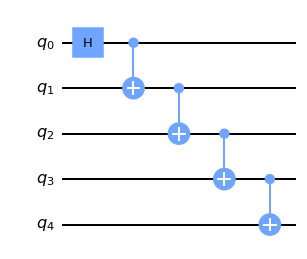

In [12]:
qc = qk.QuantumCircuit(5)
qc.h(0)
for i in range(4):
    qc.cx(i, i+1)
qc.draw(output='mpl')

## Without 'n2q' gate, transpile to CX gates

In [14]:
tqc = qk.transpile(qc, montreal, initial_layout=[0,1,2,4,5])

In [15]:
tqc.draw(idle_wires=False)

┌──────────┐                                                  
      q_0 -> 0 ┤ U2(0,pi) ├──■───────────────────────────────────────────────
               └──────────┘┌─┴─┐          ┌───┐     ┌───┐     ┌───┐          
      q_1 -> 1 ────────────┤ X ├──■────■──┤ X ├──■──┤ X ├──■──┤ X ├──■───────
                           └───┘┌─┴─┐  │  └─┬─┘  │  └─┬─┘┌─┴─┐└─┬─┘┌─┴─┐     
      q_2 -> 2 ─────────────────┤ X ├──┼────┼────┼────■──┤ X ├──■──┤ X ├──■──
                           ┌───┐└───┘  │    │    │       └───┘     └───┘┌─┴─┐
ancilla_0 -> 3 ─────■──────┤ X ├──■────┼────┼────┼──────────────────────┤ X ├
                    │      └─┬─┘  │  ┌─┴─┐  │  ┌─┴─┐                    └───┘
      q_3 -> 4 ─────┼────────┼────┼──┤ X ├──■──┤ X ├─────────────────────────
                  ┌─┴─┐      │  ┌─┴─┐└───┘     └───┘                         
      q_4 -> 5 ───┤ X ├──────■──┤ X ├────────────────────────────────────────
                  └───┘         └───┘

## Running `TwoQToNativeEntangler` directly
- Can call `TwoQToNativeEntangler` on already transpiled circuit
- TwoQToNativeEntangler decomposes each 2Q gate from the transpiled circuit with instance of native gate plus 1q rotations

In [17]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import TwoQToNativeEntangler

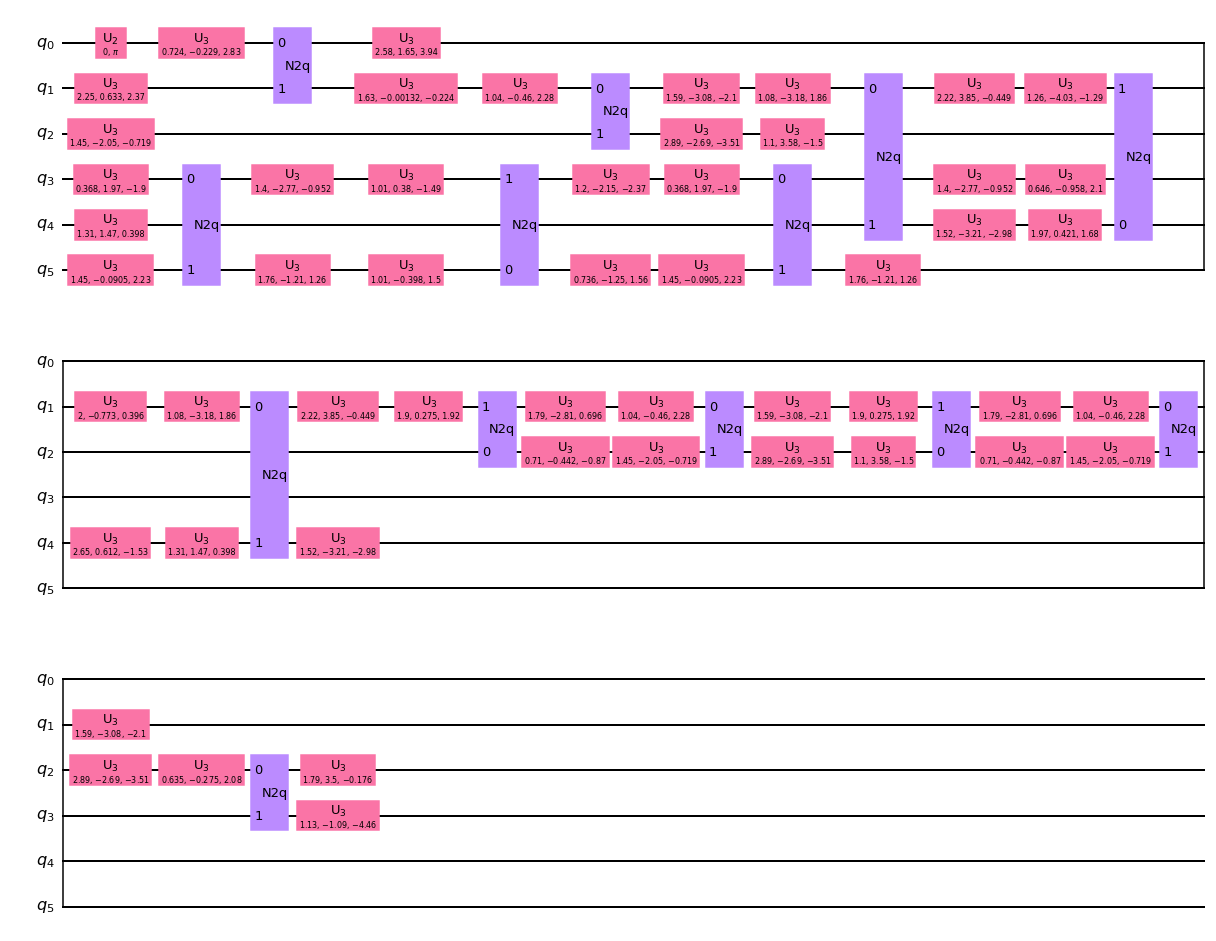

In [18]:
gate_configs = n2q_montreal.configuration().gates
basis_gates = n2q_montreal.configuration().basis_gates

pm = PassManager([
    TwoQToNativeEntangler(basis_gates, gate_configs),
])
pm.run(tqc).draw(idle_wires=False, output='mpl')

- Each CX gate is replaced with an 'n2q' plus four single qubit rotations.
- Adjacent U3 gates to be consolidated via `Optimize1qGates` or `ConsolidateBlocks`

## `ConsolidateBlocks`/`UnitarySynthesis` passes will use native gate for KAK decomposition

In [21]:
from qiskit.transpiler.passes import UnitarySynthesis, Collect2qBlocks, ConsolidateBlocks

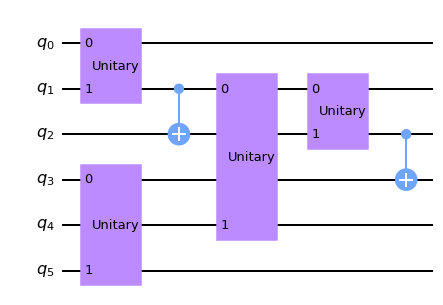

In [22]:
pm = PassManager([
    Collect2qBlocks(),
    ConsolidateBlocks(
        basis_gates=basis_gates,
        gate_configurations=gate_configs,
        force_consolidate=True),
])
pm.run(tqc).draw(output='mpl', idle_wires=False)

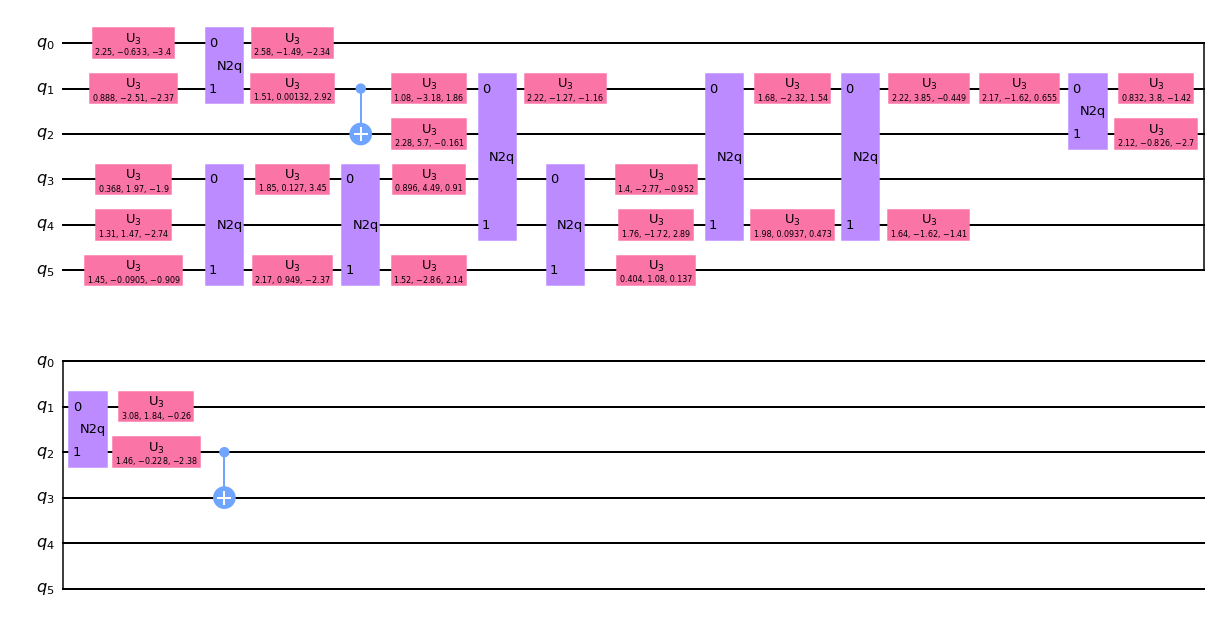

In [23]:
pm = PassManager([
    Collect2qBlocks(),
    ConsolidateBlocks(
        basis_gates=basis_gates,
        gate_configurations=gate_configs,
        force_consolidate=True),
    UnitarySynthesis(
        basis_gates=basis_gates,
        gate_configurations=gate_configs),
])
pm.run(tqc).draw(output='mpl', idle_wires=False)

- N.B. Above may still have some CX gates, because only gates that are collected into a block are decomposed by this pass 

# Integration in default pass managers

- `TwoQToNativeEntangler` is run after normal embedding/optimization process. Then optimizations are re-run.

In [26]:
from qiskit.transpiler import PassManagerConfig, CouplingMap
from qiskit.transpiler.preset_passmanagers import (level_0_pass_manager,
                                                  level_1_pass_manager,
                                                  level_2_pass_manager,
                                                  level_3_pass_manager)

In [27]:
pm_config = PassManagerConfig(
    basis_gates=basis_gates,
    coupling_map=CouplingMap(n2q_montreal.configuration().coupling_map),
    initial_layout=[0,1,2,4,5],
    gate_configurations=gate_configs)

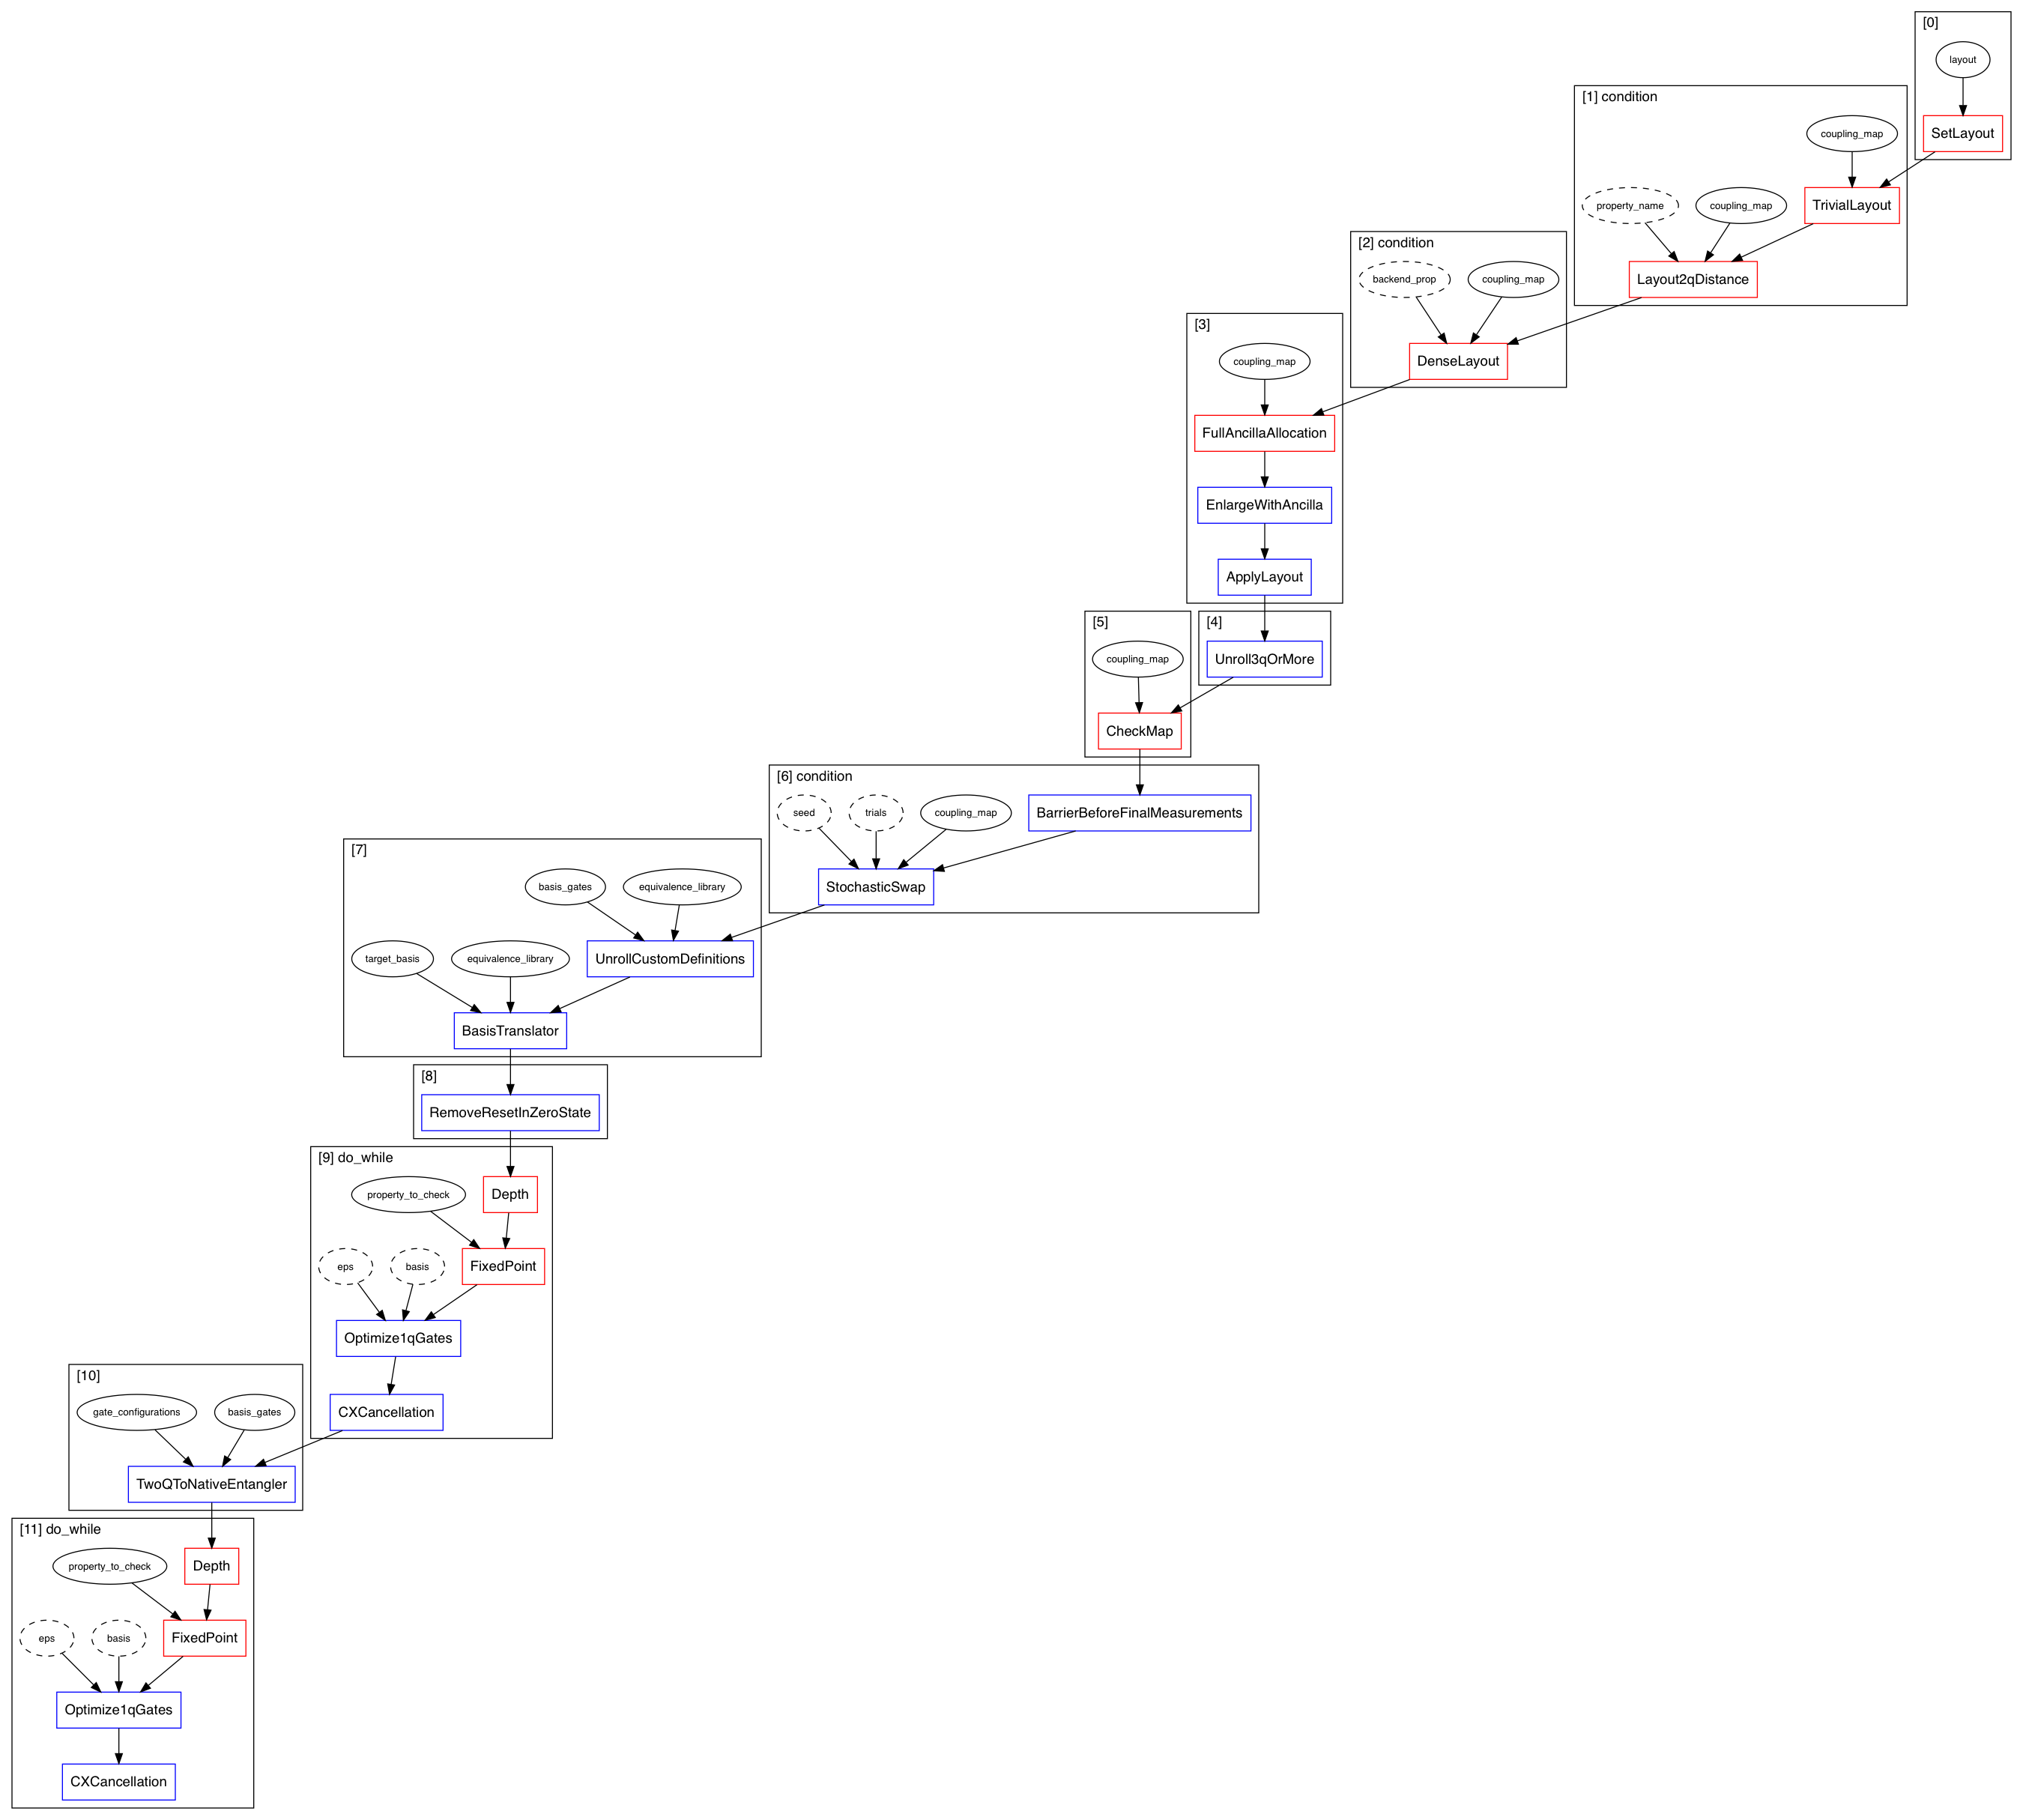

In [28]:
level_1_pass_manager(pm_config).draw()

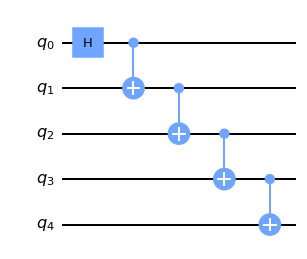

In [29]:
# Reminder
qc.draw(output='mpl')

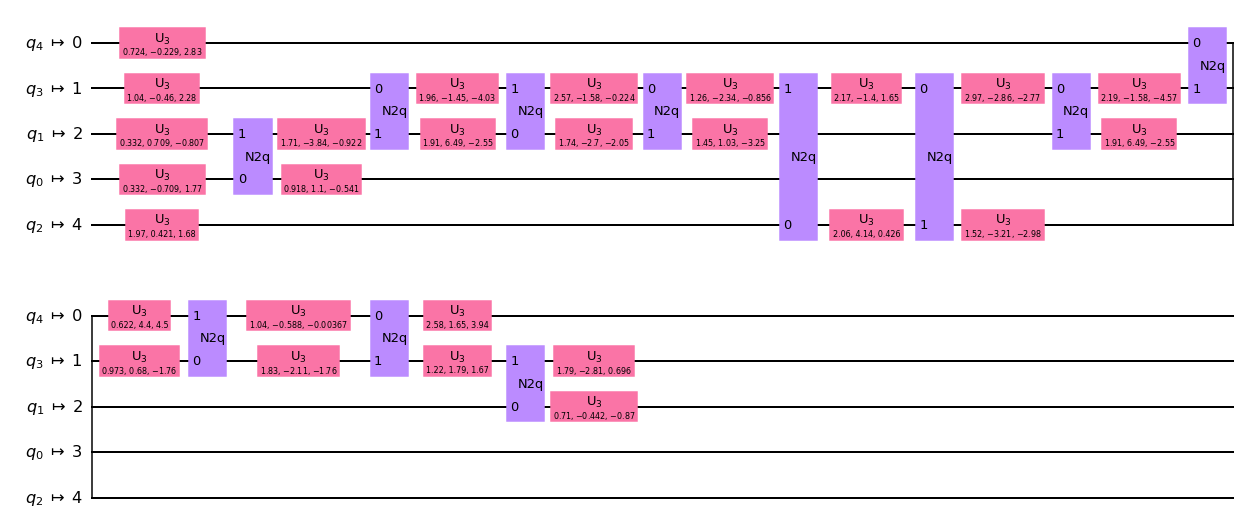

In [30]:
qk.transpile(qc, n2q_montreal, optimization_level=1).draw(output='mpl', idle_wires=False)

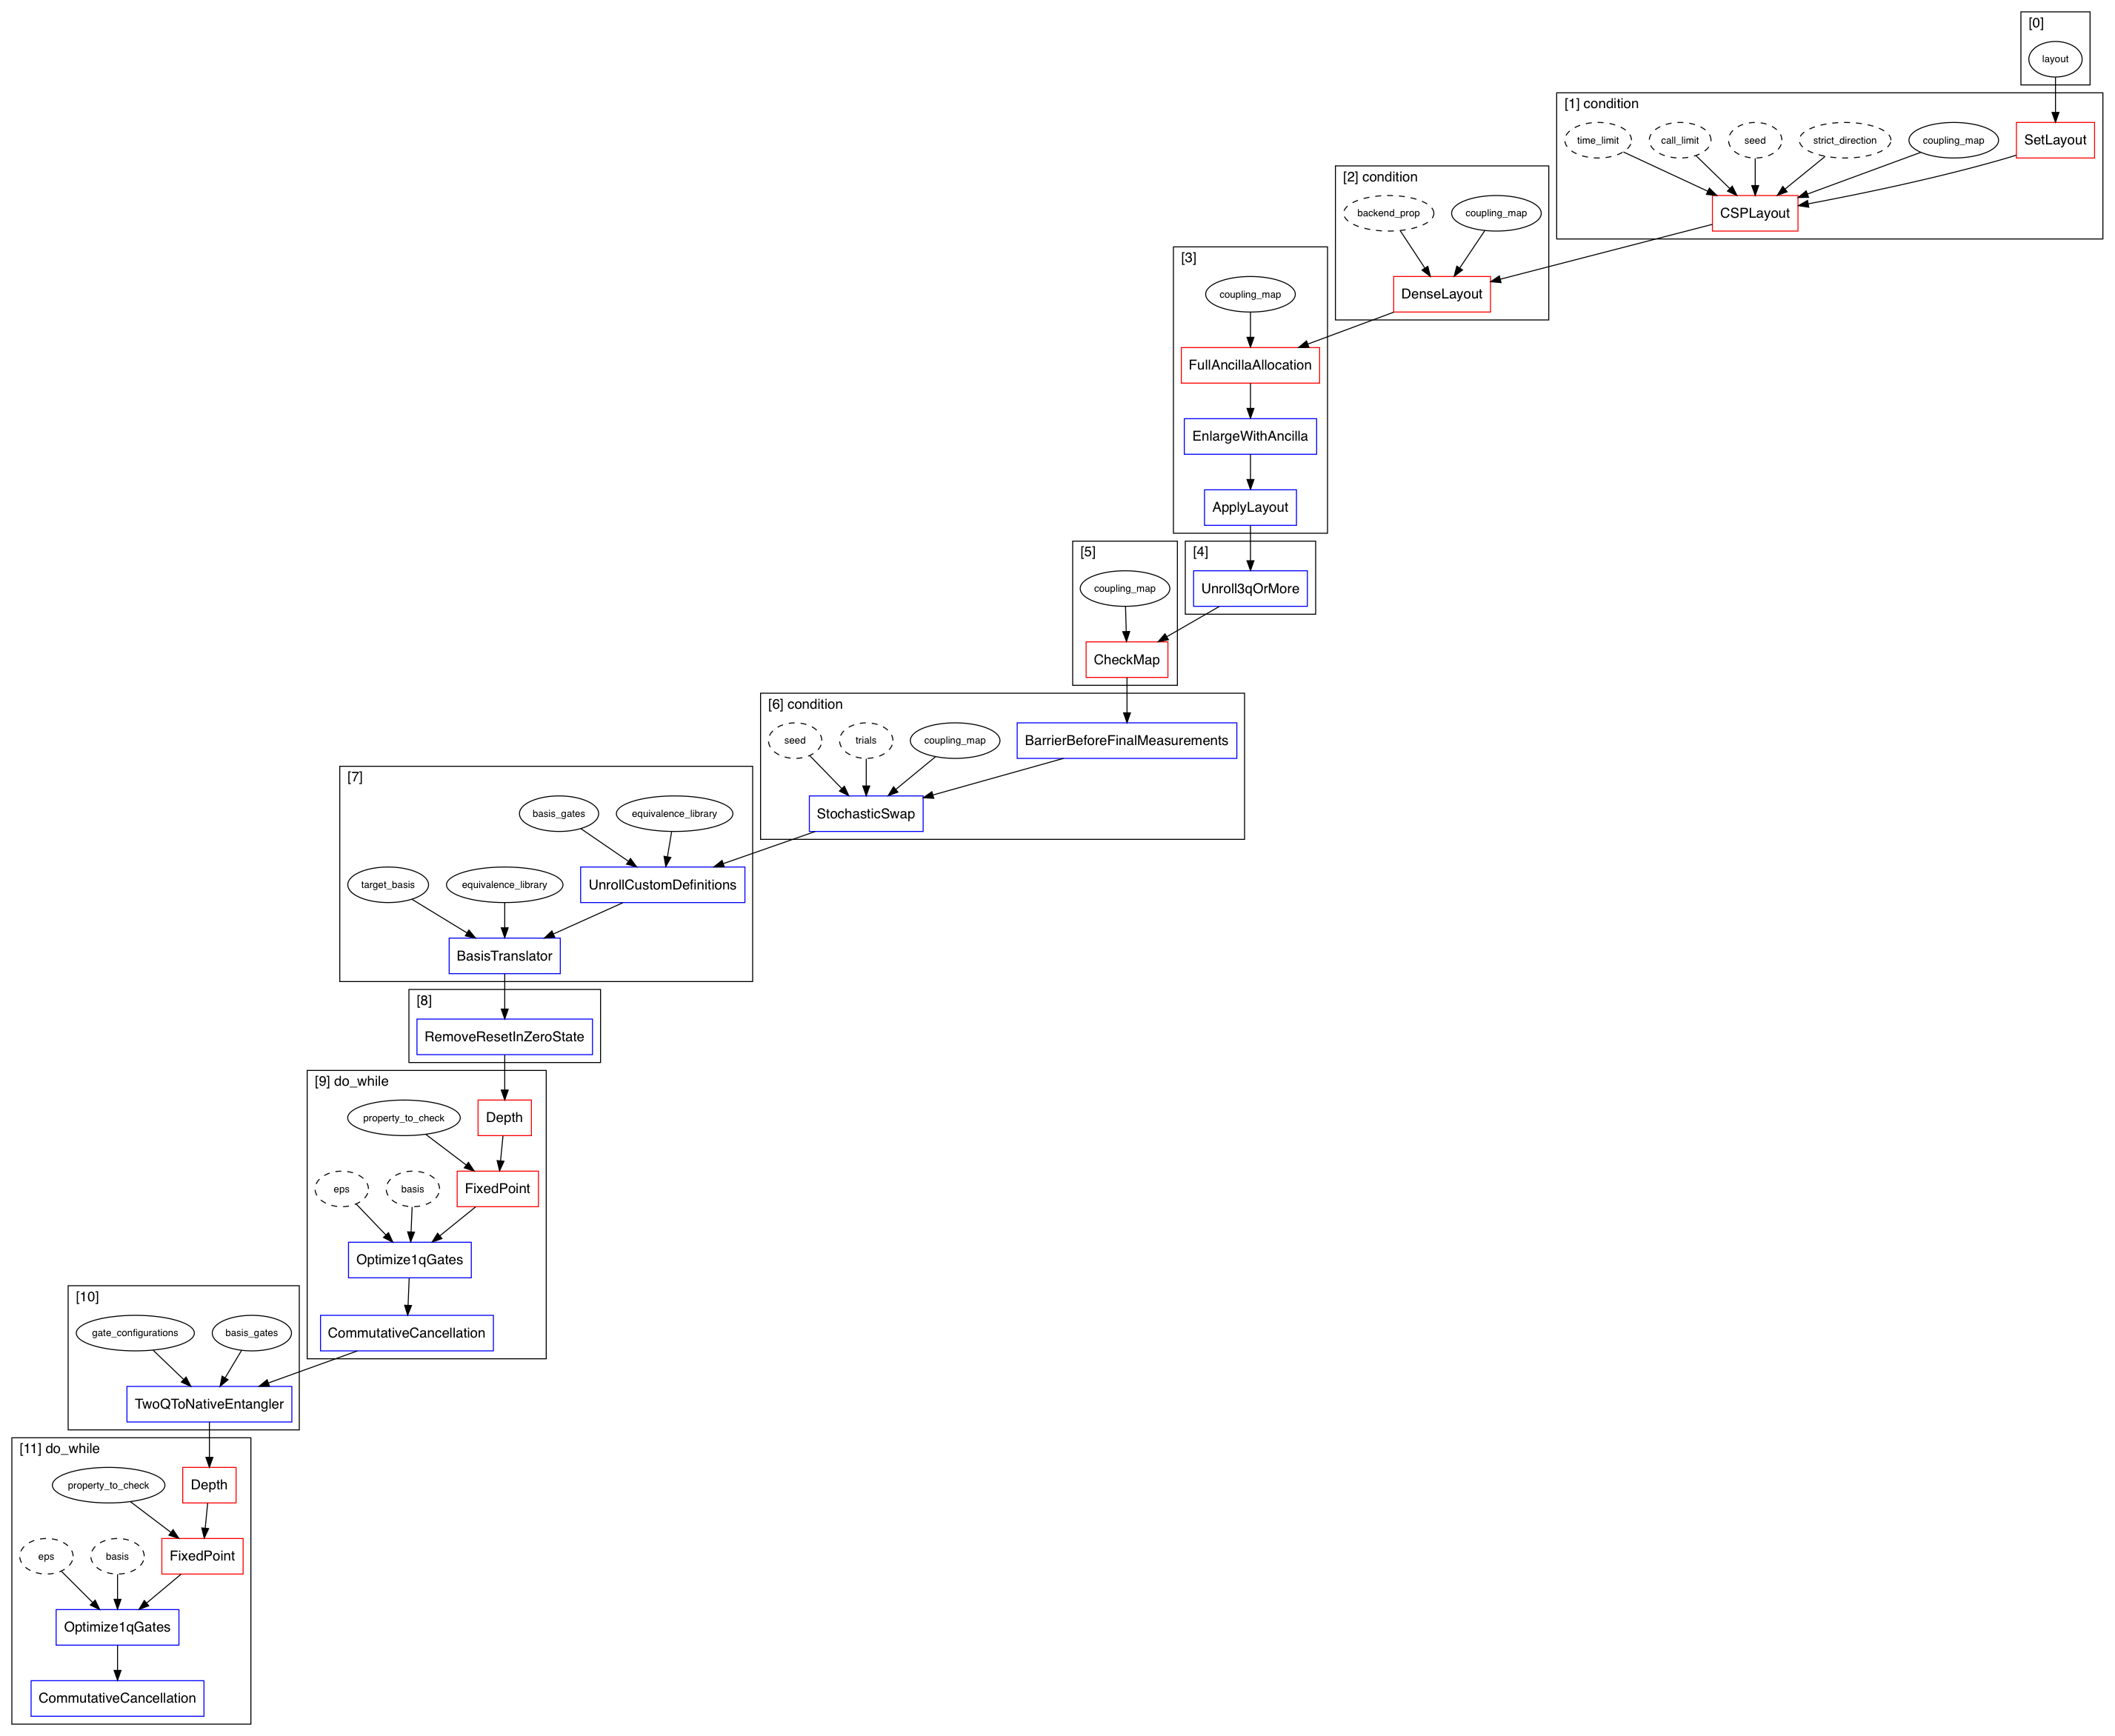

In [31]:
level_2_pass_manager(pm_config).draw()

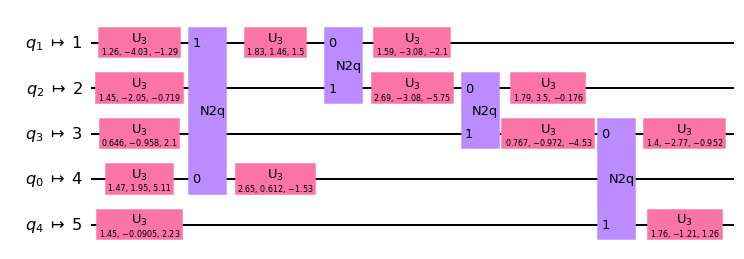

In [32]:
qk.transpile(qc, n2q_montreal, optimization_level=2).draw(output='mpl', idle_wires=False)

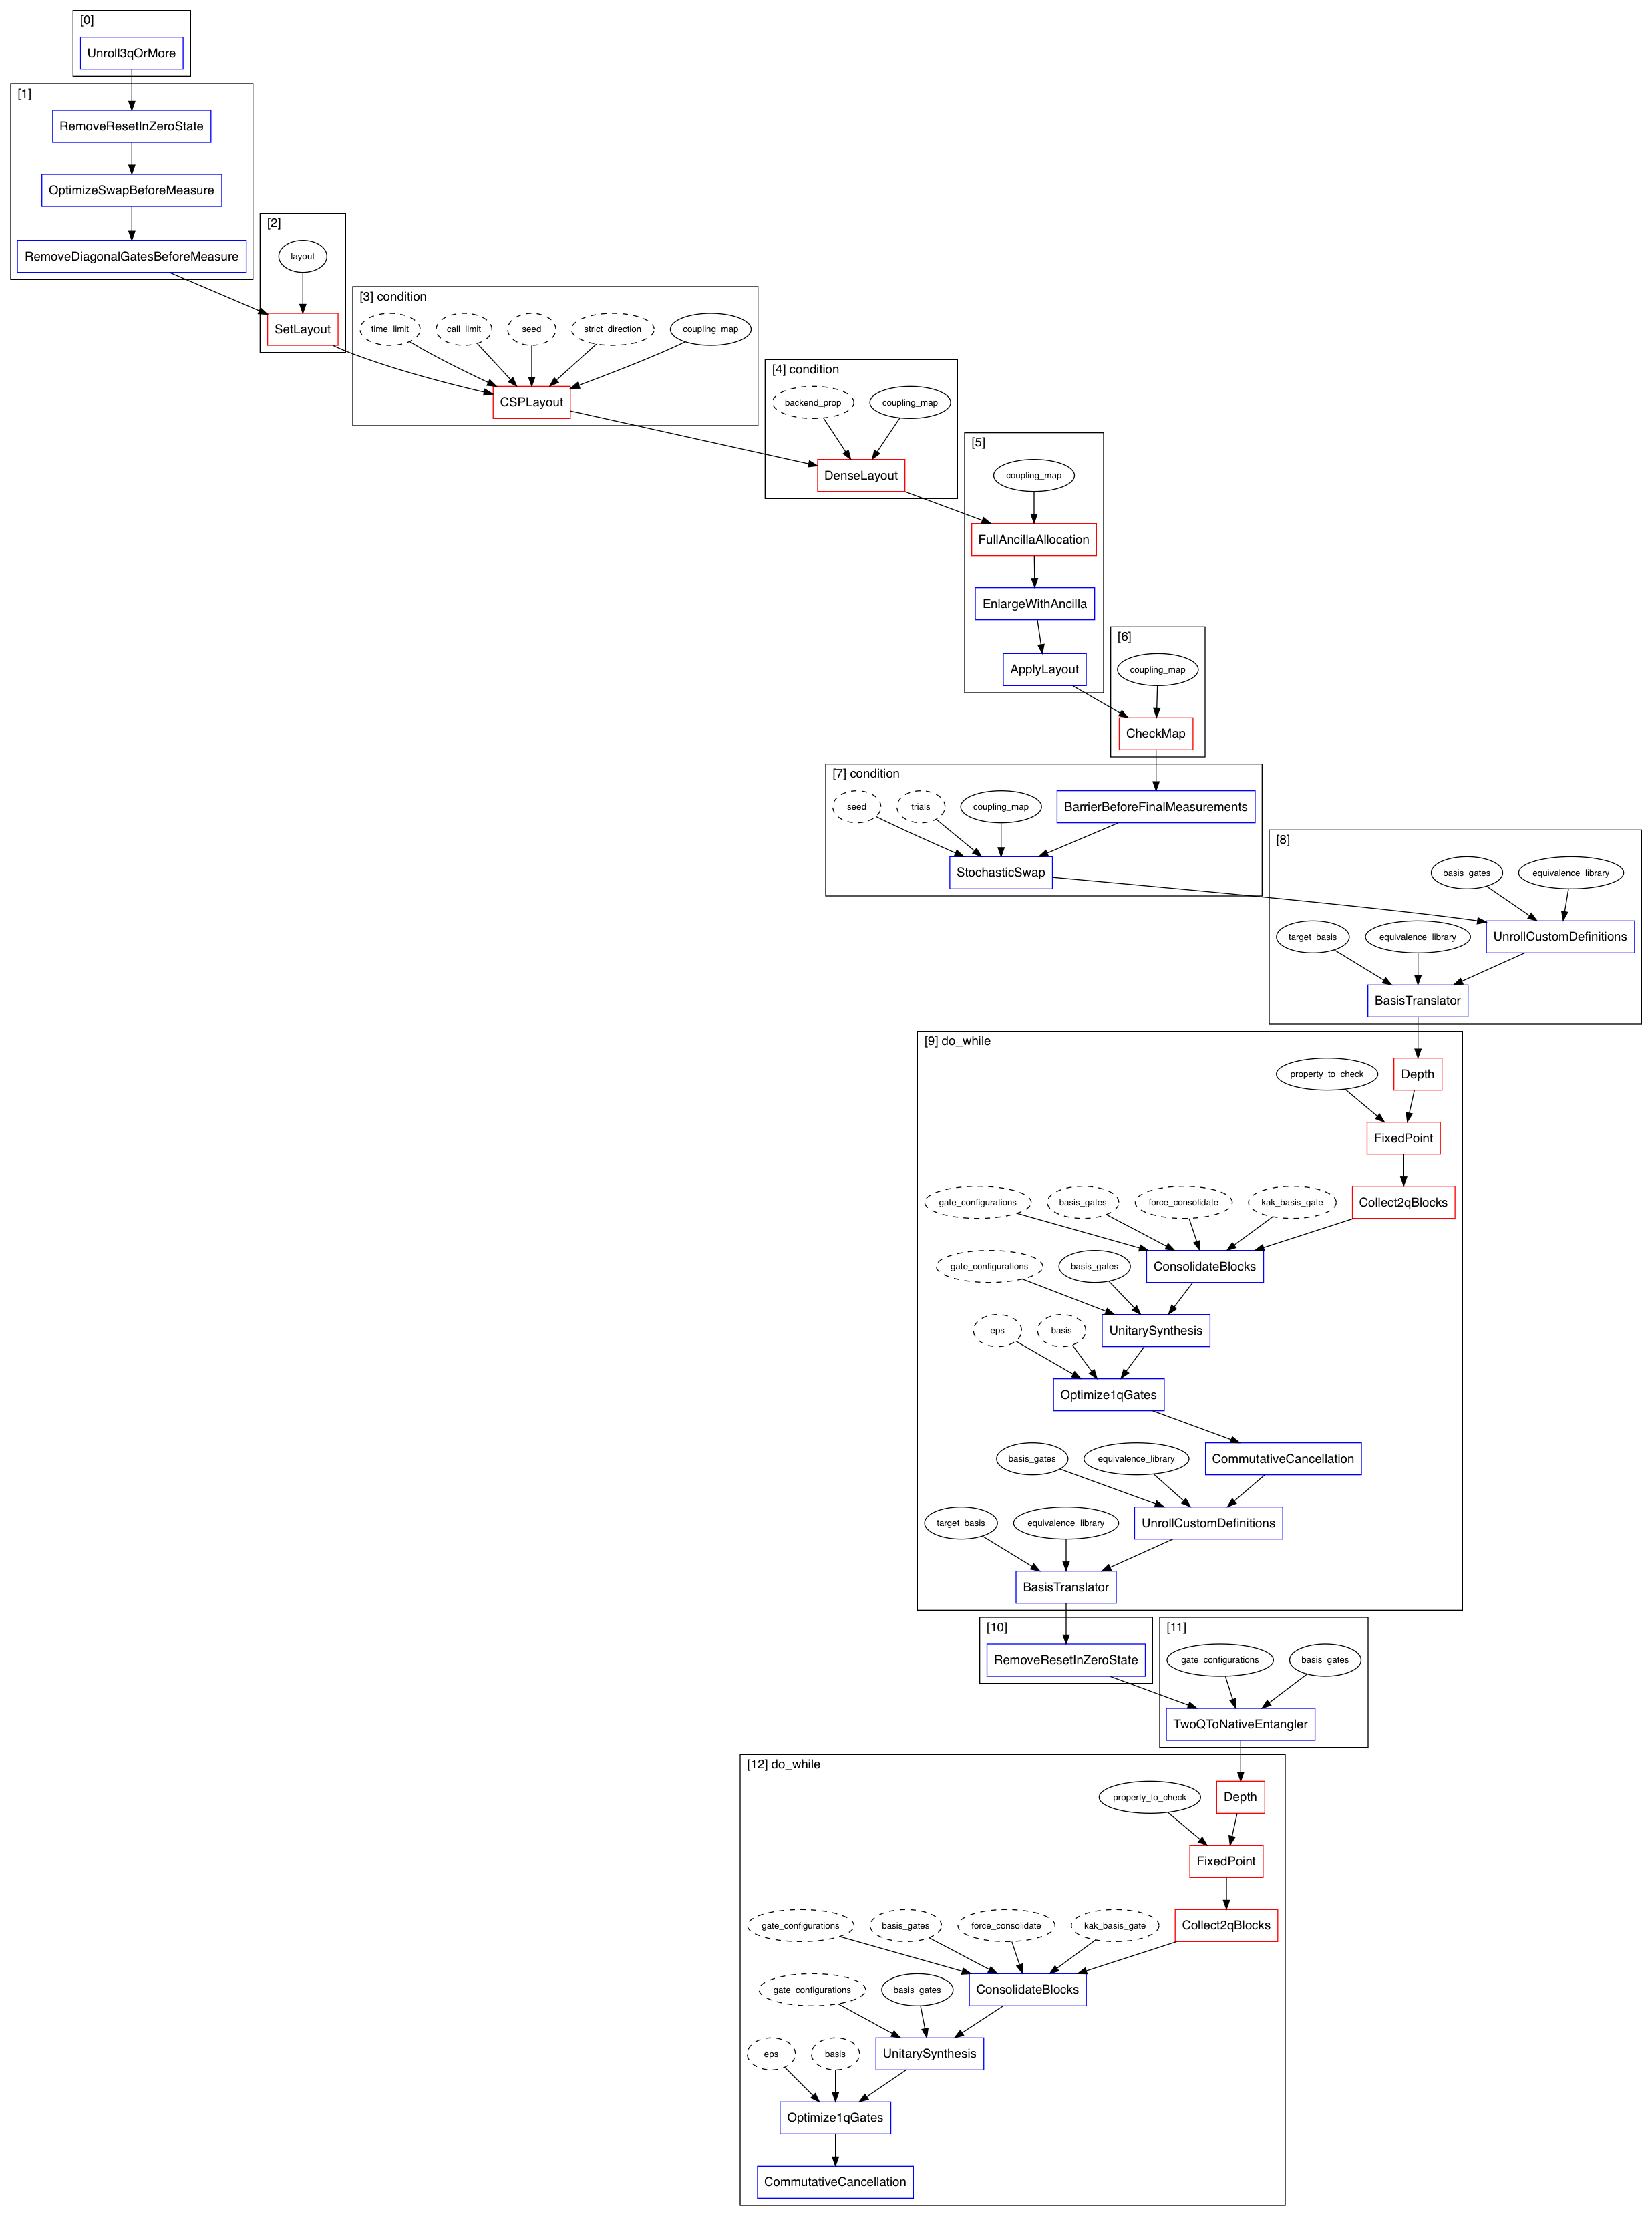

In [34]:
level_3_pass_manager(pm_config).draw()

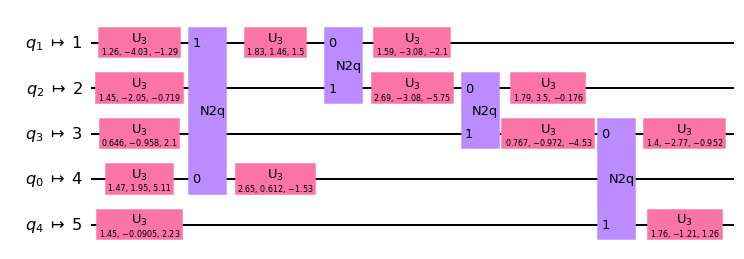

In [33]:
qk.transpile(qc, n2q_montreal, optimization_level=3).draw(output='mpl', idle_wires=False)